# Context windows

In [14]:
%matplotlib inline
from climada.hazard import TCTracks
import numpy as np
from matplotlib import pyplot as plt

In [1]:


from kooplearn.data import TrajectoryContextDataset, TensorContextDataset

# Import dependencies
import functools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import ml_confs

## Context windows for Lorenz63 system

In [2]:
from kooplearn.datasets import Lorenz63

configs = ml_confs.from_dict({
    'train_samples': 10000,
    'test_samples': 100,
})

raw_data = Lorenz63().sample(X0 = np.ones(3), T=configs.train_samples + 1000 + configs.test_samples)
mean = np.mean(raw_data, axis=0)
norm = np.max(np.abs(raw_data), axis=0)
# Data rescaling
data = raw_data - mean
data /= norm

dataset = {
    "train": data[:configs.train_samples + 1],
    "test": data[-configs.test_samples - 1:],
}

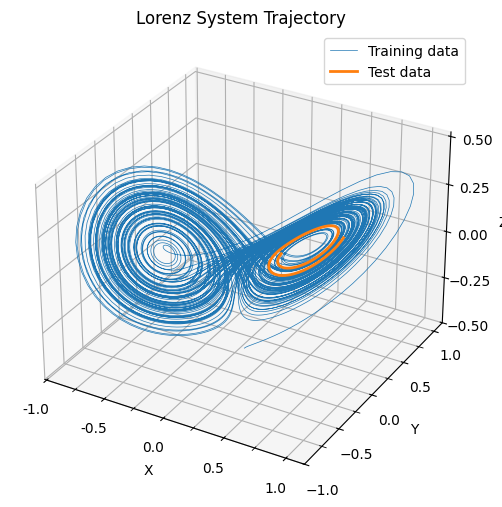

In [3]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')
ax.plot(dataset['train'][:,0], dataset['train'][:,1], dataset['train'][:,2], lw=.5, label='Training data')
ax.plot(dataset['test'][:,0], dataset['test'][:,1], dataset['test'][:,2], lw=2, label='Test data')
ax.set_title("Lorenz System Trajectory")
ax.set_xlabel("X")
ax.set_xticks(np.linspace(-1,1,5),)
ax.set_xticklabels(np.linspace(-1,1,5))
ax.set_ylabel("Y")
ax.set_yticks(np.linspace(-1,1,5))
ax.set_zlabel("Z")
ax.set_zticks(np.linspace(-.5,.5,5))

spacing = 0.25
minorLocator = MultipleLocator(spacing)
ax.yaxis.set_minor_locator(minorLocator)
ax.xaxis.set_minor_locator(minorLocator)
ax.grid(which = 'minor')

plt.legend()
plt.show()

In [4]:
dataset["train"].shape

(10001, 3)

In [5]:
context_train = TrajectoryContextDataset(dataset["train"], context_length = 10)

In [6]:
context_train.shape

(9992, 10, 3)

In [7]:
# From trajectories to context windows
contexts = {k: TrajectoryContextDataset(v, context_length = 100) for k, v in dataset.items()} # Converting the trajectories to contexts
for split, ds in contexts.items():
    print(f"{split.capitalize()} contexts have shape {ds.shape}: {len(ds)} contexts of length {ds.context_length} with {ds.shape[2]} features each")

Train contexts have shape (9902, 100, 3): 9902 contexts of length 100 with 3 features each
Test contexts have shape (2, 100, 3): 2 contexts of length 100 with 3 features each


In [8]:
contexts.keys()

dict_keys(['train', 'test'])

In [9]:
contexts["test"].shape, contexts["train"].shape

((2, 100, 3), (9902, 100, 3))

## Context windows from tropical cyclones

In [2]:
tc_tracks = TCTracks.from_ibtracs_netcdf(provider='usa', year_range=(2000, 2001), basin='EP', correct_pres=False)
print('Number of tracks:', tc_tracks.size)

d:\work\projects\repositories\koopman_learning_tropical_cyclone\.venv\lib\site-packages\xarray\backends\plugins.py:80: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


2024-06-29 14:46:02,156 - climada.hazard.tc_tracks - WARNING - The cached IBTrACS data set dates from 2023-06-07 23:07:38 (older than 180 days). Very likely, a more recent version is available. Consider manually removing the file C:\Users\Eric\climada\data\IBTrACS.ALL.v04r00.nc and re-running this function, which will download the most recent version of the IBTrACS data set from the official URL.
2024-06-29 14:46:02,892 - climada.hazard.tc_tracks - WARNING - 8 storm events are discarded because no valid wind/pressure values have been found: 2000138N16119, 2000187N12245, 2000201N11224, 2000203N17249, 2000209N06182, ...


d:\work\projects\repositories\koopman_learning_tropical_cyclone\.venv\lib\site-packages\climada\hazard\tc_tracks.py:614: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  if ibtracs_ds.dims['storm'] == 0:


Number of tracks: 36


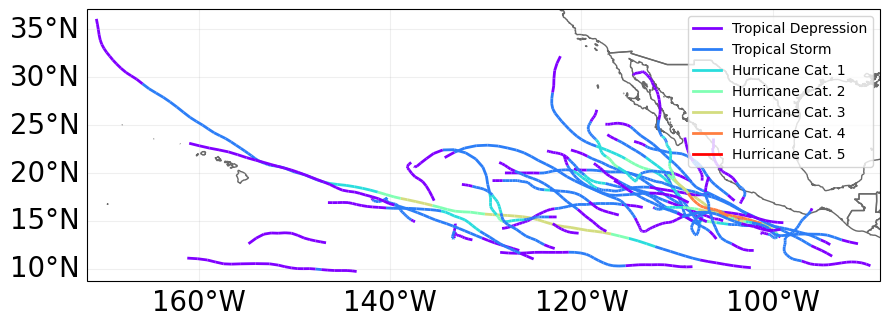

In [3]:
ax = tc_tracks.plot()

In [4]:
# tc_data = tc_tracks.data

In [5]:
from klearn_tcyclone.data_utils import data_array_list_from_TCTracks, context_dataset_from_TCTracks

In [6]:
feature_list = [
    "lat", "lon", "max_sustained_wind", "central_pressure"
]

In [7]:
data_array_list = data_array_list_from_TCTracks(tc_tracks=tc_tracks, feature_list=feature_list)

In [8]:
for data_array in data_array_list:
    print(data_array.shape)

(45, 4)
(35, 4)
(53, 4)
(107, 4)
(31, 4)
(37, 4)
(49, 4)
(49, 4)
(27, 4)
(35, 4)
(25, 4)
(73, 4)
(15, 4)
(24, 4)
(63, 4)
(31, 4)
(40, 4)
(57, 4)
(51, 4)
(17, 4)
(61, 4)
(27, 4)
(13, 4)
(55, 4)
(45, 4)
(33, 4)
(13, 4)
(37, 4)
(95, 4)
(33, 4)
(23, 4)
(23, 4)
(9, 4)
(61, 4)
(39, 4)
(31, 4)


In [9]:
context_length = 12

In [10]:
n_entries = len([x for x in data_array_list if x.shape[0] >= context_length])
n_data = np.sum([data_array.shape[0] for data_array in data_array_list if data_array.shape[0] >= context_length])
n_data - n_entries*(context_length-1)

1068

In [11]:
tensor_context_dataset = context_dataset_from_TCTracks(
    tc_tracks, feature_list=feature_list, context_length=context_length
)

C:\Users\Eric\AppData\Local\Temp\ipykernel_11360\164162217.py:1: UserWarning: Data entry 32 has been removed since it is shorter than the 
                context_length.
  tensor_context_dataset = context_dataset_from_TCTracks(


In [12]:
tensor_context_dataset.shape

(1068, 12, 4)

In [85]:
data_array = data_array_list[0]
context_train1 = TrajectoryContextDataset(data_array, context_length = 10)
data_array = data_array_list[12]
context_train2 = TrajectoryContextDataset(data_array, context_length = 10)

In [86]:
context_train1.shape, context_train2.shape

((36, 10, 4), (6, 10, 4))

In [88]:
context_train1.data

array([[[  13.3     ,  -99.2     ,   25.      , 1005.      ],
        [  13.622343,  -99.7226  ,   27.      , 1004.      ],
        [  13.9     , -100.2     ,   30.      , 1004.      ],
        ...,
        [  14.51498 , -102.15758 ,   37.      , 1001.      ],
        [  14.5     , -102.5     ,   40.      , 1001.      ],
        [  14.492432, -102.80753 ,   42.      , 1000.      ]],

       [[  13.622343,  -99.7226  ,   27.      , 1004.      ],
        [  13.9     , -100.2     ,   30.      , 1004.      ],
        [  14.129947, -100.67257 ,   30.      , 1003.      ],
        ...,
        [  14.5     , -102.5     ,   40.      , 1001.      ],
        [  14.492432, -102.80753 ,   42.      , 1000.      ],
        [  14.5     , -103.1     ,   45.      , 1000.      ]],

       [[  13.9     , -100.2     ,   30.      , 1004.      ],
        [  14.129947, -100.67257 ,   30.      , 1003.      ],
        [  14.3     , -101.1     ,   30.      , 1003.      ],
        ...,
        [  14.492432, -102.

In [55]:
context_train_full = np.concatenate([context_train1.data, context_train2.data], axis=0)

In [56]:
context_train_full.shape

(42, 10, 4)

In [57]:
tensor_context_dataset = TensorContextDataset(context_train_full)

In [59]:
tensor_context_dataset

(42, 10, 4)

In [41]:
context_train[0]

TensorContextDataset <item_count=1, context_length=10, data=[[[  13.3       -99.2        25.       1005.      ]
  [  13.622343  -99.7226     27.       1004.      ]
  [  13.9      -100.2        30.       1004.      ]
  [  14.129947 -100.67257    30.       1003.      ]
  [  14.3      -101.1        30.       1003.      ]
  [  14.429873 -101.465065   32.       1002.      ]
  [  14.5      -101.8        35.       1002.      ]
  [  14.51498  -102.15758    37.       1001.      ]
  [  14.5      -102.5        40.       1001.      ]
  [  14.492432 -102.80753    42.       1000.      ]]]>

In [44]:
context_train[0].lookback(3), context_train[0].lookforward(3)

(array([[[  13.3     ,  -99.2     ,   25.      , 1005.      ],
         [  13.622343,  -99.7226  ,   27.      , 1004.      ],
         [  13.9     , -100.2     ,   30.      , 1004.      ]]],
       dtype=float32),
 array([[[  14.129947, -100.67257 ,   30.      , 1003.      ],
         [  14.3     , -101.1     ,   30.      , 1003.      ],
         [  14.429873, -101.465065,   32.      , 1002.      ],
         [  14.5     , -101.8     ,   35.      , 1002.      ],
         [  14.51498 , -102.15758 ,   37.      , 1001.      ],
         [  14.5     , -102.5     ,   40.      , 1001.      ],
         [  14.492432, -102.80753 ,   42.      , 1000.      ]]],
       dtype=float32))

In [21]:
context_train

TrajectoryContextDataset <item_count=36, context_length=10, data=[[[  13.3       -99.2        25.       1005.      ]
  [  13.622343  -99.7226     27.       1004.      ]
  [  13.9      -100.2        30.       1004.      ]
  ...
  [  14.51498  -102.15758    37.       1001.      ]
  [  14.5      -102.5        40.       1001.      ]
  [  14.492432 -102.80753    42.       1000.      ]]

 [[  13.622343  -99.7226     27.       1004.      ]
  [  13.9      -100.2        30.       1004.      ]
  [  14.129947 -100.67257    30.       1003.      ]
  ...
  [  14.5      -102.5        40.       1001.      ]
  [  14.492432 -102.80753    42.       1000.      ]
  [  14.5      -103.1        45.       1000.      ]]

 [[  13.9      -100.2        30.       1004.      ]
  [  14.129947 -100.67257    30.       1003.      ]
  [  14.3      -101.1        30.       1003.      ]
  ...
  [  14.492432 -102.80753    42.       1000.      ]
  [  14.5      -103.1        45.       1000.      ]
  [  14.549961 -103.399956   